# Creating a Subcellular Localization Reference for OmicsIntegrator2

In [4]:
%pylab inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import mygene

Populating the interactive namespace from numpy and matplotlib


## I. Parse COMPARTMENTS database into DataFrames

In [2]:
experiments_full = pd.read_csv('./human_compartment_experiments_full.tsv', sep='\t', header=None, names=['Ensembl','GeneSymbol','GO','location','evidence_type','evidence','confidence'])
experiments_full.head()

,Ensembl,GeneSymbol,GO,location,evidence_type,evidence,confidence
0,ENSP00000000442,ESRRA,GO:0005575,cellular_component,HPA,Weak: 1 antibody,1
1,ENSP00000000442,ESRRA,GO:0005622,Intracellular,HPA,Weak: 1 antibody,1
2,ENSP00000000442,ESRRA,GO:0005623,Cell,HPA,Weak: 1 antibody,1
3,ENSP00000000442,ESRRA,GO:0005634,Nucleus,HPA,Weak: 1 antibody,1
4,ENSP00000000442,ESRRA,GO:0005730,Nucleolus,HPA,Weak: 1 antibody,1


In [3]:
knowledge_full = pd.read_csv('./human_compartment_knowledge_full.tsv', sep='\t', header=None, names=['Ensembl','GeneSymbol','GO','location','evidence','evidence_type','confidence'])
knowledge_full.head()

,Ensembl,GeneSymbol,GO,location,evidence,evidence_type,confidence
0,ENSP00000000233,ARF5,GO:0005575,cellular_component,Ensembl,IEA,2
1,ENSP00000000233,ARF5,GO:0005575,cellular_component,UniProtKB,IDA,5
2,ENSP00000000233,ARF5,GO:0005575,cellular_component,UniProtKB-SubCell,IEA,3
3,ENSP00000000233,ARF5,GO:0005576,Extracellular region,UniProtKB,IDA,5
4,ENSP00000000233,ARF5,GO:0005622,Intracellular,UniProtKB-SubCell,IEA,3


## II. Merge DataFrames into single reference

In [4]:
df = pd.concat((experiments_full,knowledge_full))
df.head()

,Ensembl,GO,GeneSymbol,confidence,evidence,evidence_type,location
0,ENSP00000000442,GO:0005575,ESRRA,1,Weak: 1 antibody,HPA,cellular_component
1,ENSP00000000442,GO:0005622,ESRRA,1,Weak: 1 antibody,HPA,Intracellular
2,ENSP00000000442,GO:0005623,ESRRA,1,Weak: 1 antibody,HPA,Cell
3,ENSP00000000442,GO:0005634,ESRRA,1,Weak: 1 antibody,HPA,Nucleus
4,ENSP00000000442,GO:0005730,ESRRA,1,Weak: 1 antibody,HPA,Nucleolus


## III. Filter DataFrame and group by gene symbol

#### i. Remove non-specific locations

In [5]:
nonspecific = ["cellular_component", "Cell", "Cell part", "Intracellular"]
df = df[~df.location.isin(nonspecific)]
df.head()

,Ensembl,GO,GeneSymbol,confidence,evidence,evidence_type,location
3,ENSP00000000442,GO:0005634,ESRRA,1,Weak: 1 antibody,HPA,Nucleus
4,ENSP00000000442,GO:0005730,ESRRA,1,Weak: 1 antibody,HPA,Nucleolus
5,ENSP00000000442,GO:0005856,ESRRA,1,Weak: 1 antibody,HPA,Cytoskeleton
6,ENSP00000000442,GO:0005874,ESRRA,1,Weak: 1 antibody,HPA,Microtubule
7,ENSP00000000442,GO:0015630,ESRRA,1,Weak: 1 antibody,HPA,Microtubule cytoskeleton


#### ii. Transform representation to extract important information

In [6]:
locations = df.groupby('GeneSymbol').apply(lambda x: x[['location','confidence']].to_records(index=False))
locations.head()

GeneSymbol
61E3.4       [[Nucleus, 4], [Nucleoplasm, 4], [Membrane, 3]...
A-575C2.4    [[Nucleus, 4], [Nucleoplasm, 4], [membrane-enc...
A1BG         [[Extracellular region, 5], [Extracellular reg...
A1CF         [[Nucleus, 1], [Organelle, 1], [membrane-bound...
A2M          [[Nucleus, 1], [Nucleolus, 1], [Cytoplasm, 1],...
dtype: object

In [8]:
locations.to_pickle('genes_and_locations.pickle')

## IV. Map to broad categories of locations

In [76]:
locations = pd.read_pickle('genes_and_locations.pickle')
locations.head()

GeneSymbol
61E3.4       [[Nucleus, 4], [Nucleoplasm, 4], [Membrane, 3]...
A-575C2.4    [[Nucleus, 4], [Nucleoplasm, 4], [membrane-enc...
A1BG         [[Extracellular region, 5], [Extracellular reg...
A1CF         [[Nucleus, 1], [Organelle, 1], [membrane-bound...
A2M          [[Nucleus, 1], [Nucleolus, 1], [Cytoplasm, 1],...
dtype: object

In [77]:
def get_broad_location(l):
    l = l.lower()
    if ("mitochond" in l) or ("respir" in l):
        return "mitochondria"
    elif ("golgi" in l):
        return "golgi"
    elif ("endosom" in l):
        return "endosome"
    elif ("perox" in l) or ("microbod" in l):
        return "peroxisome"
    elif ("endoplasmic reticulum" in l) or ("sarcoplas" in l) or ("signal recog" in l):
        return "ER"
    elif ("lytic" in l) or ("lyso" in l):
        return "lysosome"
    elif ("nucleolus" in l) or ("fibrillar" in l):
        return "nucleolus"
    elif  ("snrnp" in l) or ("repli" in l) or ("splice" in l) or ("replic" in l) or ("kineto" in l) or ("nucl" in l) or ("polymerase" in l) or ("chrom" in l) or ("dna" in l) or ("centrosome" in l):
        return "nucleus"
    elif ("endomemb" in l) or ("copi" in l) or ("granule" in l):
        return "endomembrane"
    elif ("intracell" in l):
        return "intracellular"
    elif ("riboso" in l):
        return "ribosome"
    elif ("aggresome" in l) or ("proteasome" in l):
        return "proteasome"
    elif ("exocyt" in l) or ("exosome" in l) or ("extracellular" in l) or ("cell-cell" in l):
        return "extracellular"
    elif ("leading edge" in l) or ("filopo" in l) or ("cortex" in l) or ("desmo" in l) or ("centrio" in l) or ("myosin" in l) or ("lamell" in l) or ("microtub" in l) or ("ruffle" in l) or ("cytoske" in l) or ("cili" in l) or ("actin" in l) or ("focal ad" in l) or ("projection" in l) or ("adhere" in l) or ("junction" in l) or ("contractile" in l) or ("kinesin" in l) or ("filament" in l) or ("spindle" in l):
        return "cytoskeleton"
    elif ("phago" in l) or ("pino" in l):
        return "phagocytic"
    elif ("organelle" in l):
        return "organelle"
    elif ("vesic" in l) or ("vacuol" in l):
        return "vesicle"
    elif ("apical" in l) or ("membr" in l) or ("periph" in l) or ("furrow" in l) or ("surface" in l):
        return "membrane"
    elif ("macromol" in l) or ("complex" in l) or ("supramol" in l):
        return "protein complex"
    elif ("cytoplasm" in l) or ("cytosol" in l):
        return "cytoplasm"
    elif ("cell body" in l) or ("ranvier" in l) or ("synap" in l) or ("cajal" in l) or ("bouton" in l) or ("neuron" in l) or ("cone" in l) or ("axon" in l) or ("dendrit" in l) or ("perik" in l): 
        return "neuron"
    elif ("tubule" in l) or ("sarco" in l) or ("zone" in l) or ("fibril" in l) or ("myelin" in l) or ("disc" in l) or ("band" in l):
        return "muscle"
    elif ("lipopro" in l) or ("chylo" in l):
        return "lipoprotein"
    else:
        return "bad_location"

In [78]:
locations = locations.apply(lambda locations_and_confidences: [(get_broad_location(l),c) for l,c in locations_and_confidences])
locations.head()

GeneSymbol
61E3.4       [(nucleus, 4), (nucleus, 4), (membrane, 3), (m...
A-575C2.4    [(nucleus, 4), (nucleus, 4), (membrane, 4), (n...
A1BG         [(extracellular, 5), (extracellular, 5), (extr...
A1CF         [(nucleus, 1), (organelle, 1), (organelle, 1),...
A2M          [(nucleus, 1), (nucleolus, 1), (cytoplasm, 1),...
dtype: object

## V. Take max confidence over location categories

In [79]:
non_organelle_list = ["extracellular", "organelle", "intracellular", "membrane", "cytoplasm" "cytoskeleton", 
                      "protein complex", "neuron", "muscle", "lipoprotein"]
non_cytoplasmic = ["extracellular", "organelle", "intracellular", "membrane", "cytoplasm" "cytoskeleton", 
                      "protein complex", "neuron", "muscle", "lipoprotein", "nucleus", "nucleolus"]
endomembrane_list = ["ER", "golgi", "endosome", "lysosome", "peroxisome", "phagocytic"]

def sort_compartment(elements):
    my_dict = {}
    for element in elements:
        if element[1] >= 3 and element[0] != "bad_location":
            my_dict[element[0]] = my_dict.get(element[0], 0) + element[1] - 2
    d = [k for k in sorted(my_dict, key=my_dict.get, reverse=True)]
    if ("intracellular" in d) and sum([True for x in d if (x not in ["extracellular", "intracellular", "membrane"]) ]) > 0 and len(d) > 1:
        d.remove('intracellular')
    if ("organelle" in d) and sum([True for x in d if (x not in non_organelle_list) ]) > 0 and len(d) > 1:
        d.remove('organelle')
    if ("cytoplasm" in d) and sum([True for x in d if (x not in non_cytoplasmic) ]) > 0 and len(d) > 1:
        d.remove('cytoplasm')
    if ("endomembrane" in d) and sum([True for x in d if (x in endomembrane_list) ]) > 0 and len(d) > 1:
        d.remove('endomembrane')
    if ("nucleus" in d) and ("nucleolus" in d):
        d.remove('nucleus')
        d.append('nucleus')
    if ('membrane' in d) and len(d) > 1:
        d.remove('membrane')
        d.append('membrane')
    if ('neuron' in d) and len(d) > 1:
        d.remove('neuron')
        d.append('neuron')
    if ('muscle' in d) and len(d) > 1:
        d.remove('muscle')
        d.append('muscle')
        
    if len(d) > 1:
        return (d[0], d[1:min(3, len(d))])
    elif len(d) == 1:
        return (d[0], None)
    return ("no location", None)


locations = locations.apply(sort_compartment)
locations.head()

GeneSymbol
61E3.4                          (nucleus, [membrane])
A-575C2.4                       (nucleus, [membrane])
A1BG         (extracellular, [endomembrane, vesicle])
A1CF                 (nucleus, [protein complex, ER])
A2M          (extracellular, [vesicle, endomembrane])
dtype: object

In [80]:
locations = locations.to_frame().rename(columns={0:'location_and_otherLocations'})
locations['location'], locations['otherLocations'] = zip(*locations['location_and_otherLocations'])
del locations['location_and_otherLocations']
locations.head()

,location,otherLocations
GeneSymbol,,
61E3.4,nucleus,[membrane]
A-575C2.4,nucleus,[membrane]
A1BG,extracellular,"[endomembrane, vesicle]"
A1CF,nucleus,"[protein complex, ER]"
A2M,extracellular,"[vesicle, endomembrane]"


## VI. Namespace mapping

#### i. Query Mygene

In [53]:
mg = mygene.MyGeneInfo()
results = mg.querymany(locations.index.tolist(), scopes=['symbol','alias'], fields=["symbol"], species="human", as_dataframe=True, returnall=True)
duplicated = results['dup']
missing = results['missing']
out = results['out']

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-18114...done.
Finished.
1404 input query terms found dup hits:
	[('61E3.4', 2), ('A1BG', 2), ('AATK', 2), ('ABP1', 2), ('ACAT1', 2), ('ACAT2', 2), ('ACP1', 2), ('AC
101 input query terms found no hit:
	['C6orf50', 'ENSG00000064489', 'ENSG00000108825', 'ENSG00000166329', 'ENSG00000169203', 'ENSG0000017


#### ii. Don't concern ourselves with missing entries. We can keep them around without any trouble. 

In [54]:
found = out[out.notfound != True]['symbol']
found.head()

query
61E3.4         NPIPB4
61E3.4           SMG1
A-575C2.4      NPIPB7
A1BG             A1BG
A1BG         A1BG-AS1
Name: symbol, dtype: object

#### iii. Throw away all the secondary symbols for which we were given duplicates

In [55]:
found = found[~found.index.duplicated(keep='first')]
found.head()

query
61E3.4       NPIPB4
A-575C2.4    NPIPB7
A1BG           A1BG
A1CF           A1CF
A2M             A2M
Name: symbol, dtype: object

#### iv. Replace the GeneSymbols which we got updated names from MyGene for

In [56]:
len(found), len(found[found.index != found.values])

(18013, 854)

In [57]:
found[found.index != found.values].head()

query
61E3.4       NPIPB4
A-575C2.4    NPIPB7
ABP1           DBNL
ACN9         SDHAF3
ACPL2        PXYLP1
Name: symbol, dtype: object

In [81]:
locations = locations.merge(found.to_frame(), how='left', left_index=True, right_index=True).reset_index()
locations['symbol'] = locations['symbol'].fillna(locations['GeneSymbol'])
locations = locations.set_index('symbol')[['location', 'otherLocations']]
locations.head()

,location,otherLocations
symbol,,
NPIPB4,nucleus,[membrane]
NPIPB7,nucleus,[membrane]
A1BG,extracellular,"[endomembrane, vesicle]"
A1CF,nucleus,"[protein complex, ER]"
A2M,extracellular,"[vesicle, endomembrane]"


In [82]:
len(locations), len(locations[~locations.index.duplicated(keep='first')])

(18114, 18054)

In [83]:
locations = locations[~locations.index.duplicated(keep='first')]
locations.head()

,location,otherLocations
symbol,,
NPIPB4,nucleus,[membrane]
NPIPB7,nucleus,[membrane]
A1BG,extracellular,"[endomembrane, vesicle]"
A1CF,nucleus,"[protein complex, ER]"
A2M,extracellular,"[vesicle, endomembrane]"


## VII. Subcellular Localization Evaluation

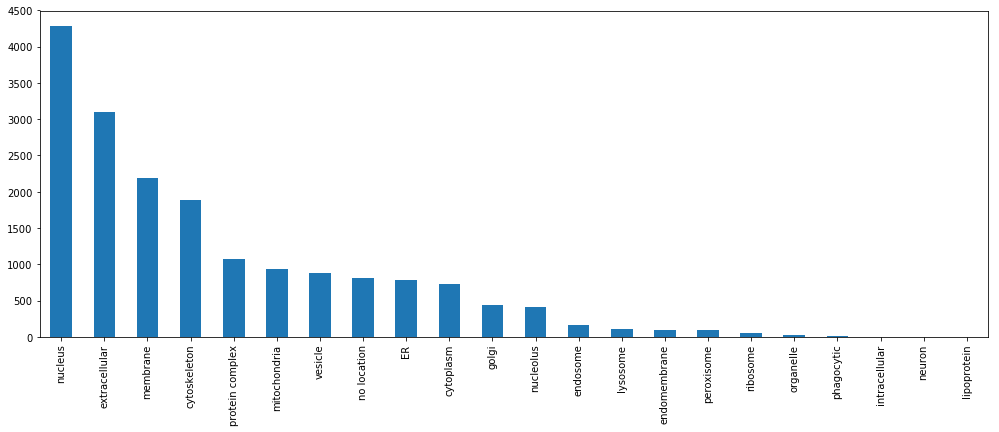

In [84]:
figure(figsize=(17, 6))
locations['location'].value_counts().plot(kind='bar')

I spot checked about 30 proteins - the localization mostly seems reasonable. The numbers also concord decently well with the data available from HPA about the total number of extracellular/nuclear/intracellular/secretory proteins. 

In [86]:
locations['location'].to_pickle('subcellular.pickle')